In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import ujson as json

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
import pathlib
import common

FONT_SIZE = 15
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [2]:
objective = 'byte_hit_rate'
fig_dir = '/data/zhenyus/gdrive/figures/'

In [3]:
def get_linestyle(alg):
    if alg == 'Belady':
        return '--'
    else:
        return '-'

In [4]:
marker_map = {
    'Belady': '1',
    'S4LRU': 'd',
    'LFUDA': 'o',
    'LFU': 'o',
    'Adaptive-TinyLFU': 'v',
#     'BeladySample': '#000080',
    'GDBT': '*',
#     'LR': 'r',
    'LRUK': '>',
    
    'GDSF': '8',
    'LRU': 's',
    'FIFO': 's',
    
#     'Hyperbolic': 'chartreuse',
    'LeCaR': 'p',
    'AdaptSize': 'P',
    'LHD': '+',
    'GDWheel': 'x',
    
}

In [5]:
color_map = {
    'Belady': 'k',
#     'BeladySample': '#000080',
    'GDBT': 'b',
#     'LR': 'r',
    'LRUK': 'g',
    'FIFO': 'r',
    'LFUDA': '#808080',
#     'GDSF': 'm',
    'LRU': 'm',
    'LFU': '#808080',
    'S4LRU': '#FC0FC0',
    'LHD': 'r',
#     'Hyperbolic': 'chartreuse',
    'LeCaR': '#ed740b',
#     'AdaptSize': '#669999',

#     'GDWheel': '#000080',
    'Adaptive-TinyLFU': 'burlywood',
}

In [6]:
warmup_map = {
    'anonymous_200m.tr': 20000000,
    'memc_200m.tr': 20000000,
}

In [7]:
trace_map = {
    'wc200m.tr': 'Wikipedia',
    'wc400m.tr': 'Wikipedia',
    'traceHK.tr': 'CDN Asia',
    'traceUS.tr': 'CDN East Cost',
    'memc_200m.tr': 'Memcachier',
    'msr_rehash_200m.tr': 'MSR Storage',
    'anonymous_200m.tr': 'Anonymous Application',
    'caida_cache_200m.tr': 'Caida',
}

In [8]:
def label_map(alg):
    if alg == 'Adaptive-TinyLFU':
        return 'TinyLFU'
    elif alg == 'GDBT':
        return 'WLC'
    return alg

In [9]:
def cache_type_to_color(s: str):
    if s in color_map:
        return color_map[s]
    raise Exception(f'color {s} is not defined in color map')

In [10]:
trace_cache_sizes = {
    'traceHK.tr': {
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'traceUS.tr': {
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'wc400m.tr': {
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'memc_200m.tr':{
        67108864,
        134217728,
        268435456,
        536870912,
        1073741824,
        2147483648,
        4294967296,
        8589934592,
    },
    'msr_rehash_200m.tr':{
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'anonymous_200m.tr': {
        268435456,
        536870912,
        1073741824,
        2147483648,
        4294967296,
        8589934592,
        17179869184,
        34359738368,
    },
}

In [11]:
def top_algorithm_all_trace_csizes(df, objective='byte_hit_rate', k=4):
    top_algs = set()
    df1 = df[~df.cache_type.isin(['GDBT', 'Belady'])].groupby(['trace_file', 'cache_type', 'cache_size'])\
       .agg({objective: 'max'}).reset_index().groupby(['cache_size', 'trace_file'])
    for l, grp in df1:
        top_alg = set(grp.sort_values(by=[objective],  ascending=False).cache_type[0:k])
        top_algs = top_algs.union(top_alg)
    return top_algs

In [12]:
# globally refresh
df = common.load_reports()

In [13]:
trace = 'wc400m.tr'
scale = 2**30
scale_label = 'GB'

# df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
#     & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.cache_type == 'WLC')
    & (df.sample_rate == '64')
    & (df.batch_size == '100000')
    & (df.objective == 'byte_miss_ratio')
    & (df.uni_size == 0)
    & (df.n_warmup == 80000000)
    & (df.learning_rate == '0.1')
    & (df.num_iterations == '32')
    & (df.cache_size.isin(trace_cache_sizes[trace]))
#     & (df.cache_size == 137438953472)
#     & (df.cache_size == 17179869184)
#     & (df.cache_size == 8589934592)
#     & (df.cache_size == 4294967296)
    & ((df.version == 'forward_window') | (df.version == 'epsilon_negative'))
)

df1 = df[filter_idx].copy()

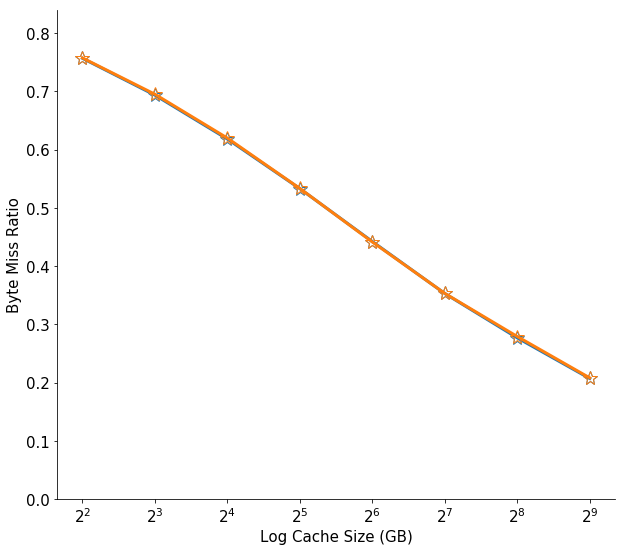

In [19]:
fig, ax = plt.subplots(figsize=(10, 9))
for version in ['forward_window', 'epsilon_negative']:
    grp = df1[df1.version == version].groupby('cache_size').agg({'byte_miss_ratio': 'min'}).reset_index()
    grp = grp.sort_values(by=['cache_size'])
    markersize = 14
    alg='GDBT'
    ax.semilogx(grp.cache_size/scale,
          grp['byte_miss_ratio'], 
#           c=cache_type_to_color(alg), 
          label=label_map(alg), 
          marker=marker_map[alg], 
          markersize=markersize,
          markerfacecolor="None",
          linestyle=get_linestyle(alg),
          basex=2)
# ax.set_xticks((8, 32, 128, 512))
# ax.set_xticklabels(('8', '32', '128', '512')) 
plt.ylim([0, 0.84])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'Log Cache Size ({scale_label})')
plt.ylabel('Byte Miss Ratio')
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
# plt.savefig(f"{fig_dir}/evaluation_wiki.pdf",
#         bbox_inches = 'tight', 
#         pad_inches = 0)
plt.show()

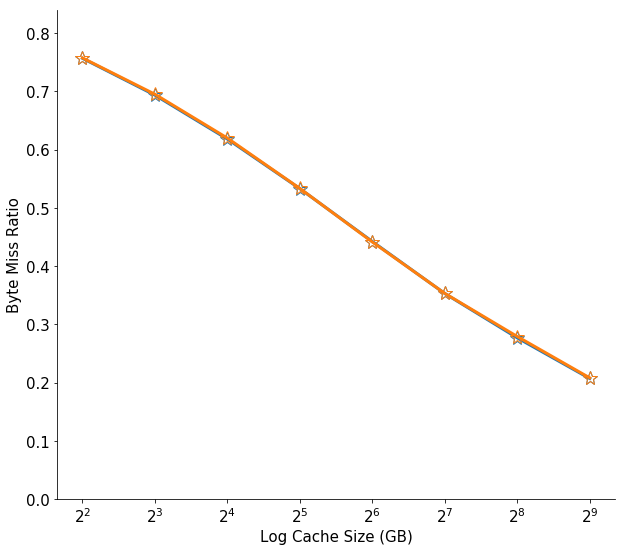

In [473]:
fig, ax = plt.subplots(figsize=(10, 9))
for version in ['forward_window', 'epsilon_negative']:
    grp = df1[df1.version == version].groupby('cache_size').agg({objective: 'max'}).reset_index()
    grp = grp.sort_values(by=['cache_size'])
    markersize = 14
    alg='GDBT'
    ax.semilogx(grp.cache_size/scale,
          1-grp[objective], 
#           c=cache_type_to_color(alg), 
          label=label_map(alg), 
          marker=marker_map[alg], 
          markersize=markersize,
          markerfacecolor="None",
          linestyle=get_linestyle(alg),
          basex=2)
# ax.set_xticks((8, 32, 128, 512))
# ax.set_xticklabels(('8', '32', '128', '512')) 
plt.ylim([0, 0.84])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'Log Cache Size ({scale_label})')
plt.ylabel('Byte Miss Ratio')
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
# plt.savefig(f"{fig_dir}/evaluation_wiki.pdf",
#         bbox_inches = 'tight', 
#         pad_inches = 0)
plt.show()

In [526]:
trace = 'msr_rehash_200m.tr'
scale = 2**30
scale_label = 'GB'

# df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
#     & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.cache_type == 'GDBT')
    & (df.sample_rate == '64')
    & (df.batch_size == '100000')
    & (df.objective == 'byte_hit_rate')
    & (df.uni_size == 0)
    & (df.n_warmup == 100000000)
    & (df.learning_rate == '0.1')
    & (df.num_iterations == '32')
    & (df.cache_size.isin(trace_cache_sizes[trace]))
#     & (df.cache_size == 137438953472)
    & (df.cache_size == 68719476736)
#     & (df.cache_size == 17179869184)
#     & (df.cache_size == 8589934592)
#     & (df.cache_size == 4294967296)
    & (df.version == 'forward_window') 
#     & (df.version == 'epsilon_negative')
#     & (df.epsilon == '0.001')
)

df1 = df[filter_idx].copy()

In [527]:
df1.forget_window = df1.forget_window.astype(float)

In [528]:
df1 = df1.sort_values('forget_window')

In [529]:
df1[['byte_hit_rate', 'forget_window', 'epsilon']]

,byte_hit_rate,forget_window,epsilon
5422,0.461437,1048576.0,NaN
5433,0.469977,2097152.0,NaN
5439,0.469149,4194304.0,NaN
5451,0.468943,8388608.0,NaN
5462,0.471468,16777216.0,NaN
5478,0.480730,33554432.0,NaN
5486,0.510933,67108864.0,NaN
5472,0.513773,134217728.0,NaN
5465,0.511835,268435456.0,NaN
5466,0.511835,536870912.0,NaN


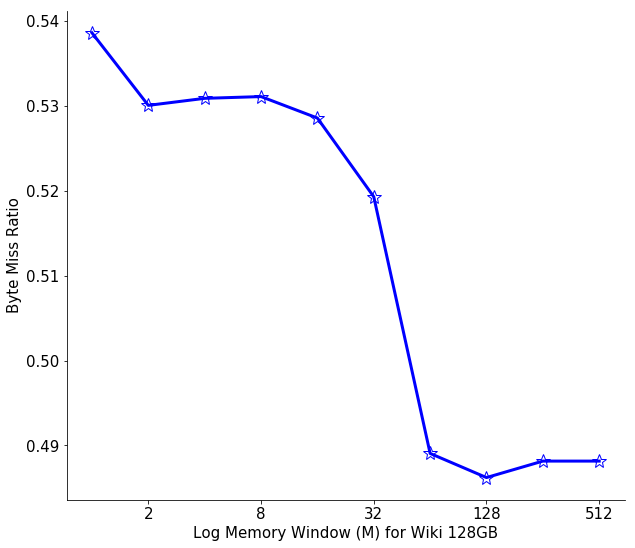

In [530]:

# plt.xlim([2**23, 2**30])

fig, ax = plt.subplots(figsize=(10, 9))
ax.semilogx(df1.forget_window/1024/1024, 
            1-df1.byte_hit_rate, 
            '-*', 
            c=cache_type_to_color('GDBT'),
            markersize=14,
            markerfacecolor="None",
            basex=2)
#     ax.semilogx(grp.cache_size/scale,
#               1-grp[objective], 
#               c=cache_type_to_color(alg), 
#               label=label_map(alg), 
#               marker=marker_map[alg], 
#               markersize=markersize,
#               markerfacecolor="None",
#               linestyle=get_linestyle(alg),
#               basex=2)
ax.set_xticks((2, 8, 32, 128, 512))
ax.set_xticklabels(('2', '8', '32', '128', '512')) 
# plt.ylim([0, 0.84])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.xlim([2, 8])
plt.xlabel(f'Log Memory Window (M) for Wiki 128GB')
plt.ylabel('Byte Miss Ratio')
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
# plt.savefig(f"{fig_dir}/evaluation_wiki.pdf",
#         bbox_inches = 'tight', 
#         pad_inches = 0)
plt.show()

In [537]:
trace = 'msr_rehash_200m.tr'
scale = 2**30
scale_label = 'GB'

# df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
#     & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.cache_type == 'GDBT')
    & (df.sample_rate == '64')
    & (df.batch_size == '100000')
    & (df.objective == 'byte_hit_rate')
    & (df.uni_size == 0)
    & (df.n_warmup == 100000000)
    & (df.learning_rate == '0.1')
    & (df.num_iterations == '32')
    & (df.cache_size.isin(trace_cache_sizes[trace]))
    & (df.cache_size == 137438953472)
#     & (df.cache_size == 68719476736)
#     & (df.cache_size == 17179869184)
#     & (df.cache_size == 8589934592)
#     & (df.cache_size == 4294967296)
    & (df.version == 'forward_window') 
#     & (df.version == 'epsilon_negative')
#     & (df.epsilon == '0.001')
)

df1 = df[filter_idx].copy()

In [538]:
df1.forget_window = df1.forget_window.astype(float)

In [539]:
df1 = df1.sort_values('forget_window')

In [540]:
df1[['byte_hit_rate', 'forget_window', 'epsilon']]

,byte_hit_rate,forget_window,epsilon
5421,0.461437,1048576.0,NaN
5426,0.470118,2097152.0,NaN
5432,0.474254,4194304.0,NaN
5440,0.474397,8388608.0,NaN
5452,0.491027,16777216.0,NaN
5460,0.497862,33554432.0,NaN
5838,0.511821,41943040.0,NaN
5841,0.544484,50331648.0,NaN
5840,0.543005,58720256.0,NaN
5467,0.590415,67108864.0,NaN


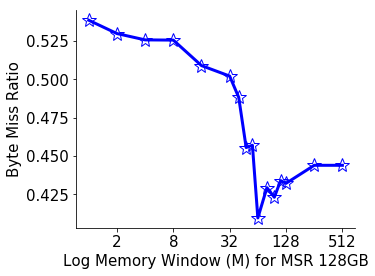

In [543]:

# plt.xlim([2**23, 2**30])

fig, ax = plt.subplots(figsize=(5, 4))
ax.semilogx(df1.forget_window/1024/1024, 
            1-df1.byte_hit_rate, 
            '-*', 
            c=cache_type_to_color('GDBT'),
            markersize=14,
            markerfacecolor="None",
            basex=2)
#     ax.semilogx(grp.cache_size/scale,
#               1-grp[objective], 
#               c=cache_type_to_color(alg), 
#               label=label_map(alg), 
#               marker=marker_map[alg], 
#               markersize=markersize,
#               markerfacecolor="None",
#               linestyle=get_linestyle(alg),
#               basex=2)
ax.set_xticks((2, 8, 32, 128, 512))
ax.set_xticklabels(('2', '8', '32', '128', '512')) 
# plt.ylim([0, 0.84])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.xlim([2, 8])
plt.xlabel(f'Log Memory Window (M) for MSR 128GB')
plt.ylabel('Byte Miss Ratio')
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
# plt.savefig(f"{fig_dir}/evaluation_wiki.pdf",
#         bbox_inches = 'tight', 
#         pad_inches = 0)
plt.show()

In [374]:
df1.groupby('cache_size').count()

,batch_size,byte_hit_rate,cache_type,cutoff,feature_overhead,forget_window,k,label,learning_rate,max_n_past_timestamps,...,sample_size,sample_type,segment_byte_hit_rate,segment_object_hit_rate,simulation_time,trace_file,training_sample_interval,uni_size,version,window
cache_size,,,,,,,,,,,,,,,,,,,,,
4.294967e+09,9,9,9,0,9,9,0,9,9,9,...,0,0,9,9,9,9,9,9,9,0
8.589935e+09,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
1.717987e+10,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
3.435974e+10,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
6.871948e+10,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
1.374390e+11,11,11,11,0,11,11,0,11,11,11,...,0,0,11,11,11,11,11,11,11,0
2.748779e+11,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
5.497558e+11,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0


In [375]:
df2 = df1[df1['byte_hit_rate'] == df1.groupby('cache_size')['byte_hit_rate'].transform(max)].drop_duplicates('cache_size').sort_values('byte_hit_rate')

In [376]:
df2['cache_size']/=1024*1024*1024
df2['forget_window']=df2['forget_window'].astype(float)
df2['forget_window']/=1024*1024

In [377]:
df2['forget_window'].astype(float)

5349      8.0
5415      8.0
5408     16.0
5400     32.0
5393     64.0
5388     64.0
5378     64.0
5368    128.0
Name: forget_window, dtype: float64

In [378]:
df2[['cache_size', 'forget_window']]

,cache_size,forget_window
5349,4.0,8.0
5415,8.0,8.0
5408,16.0,16.0
5400,32.0,32.0
5393,64.0,64.0
5388,128.0,64.0
5378,256.0,64.0
5368,512.0,128.0


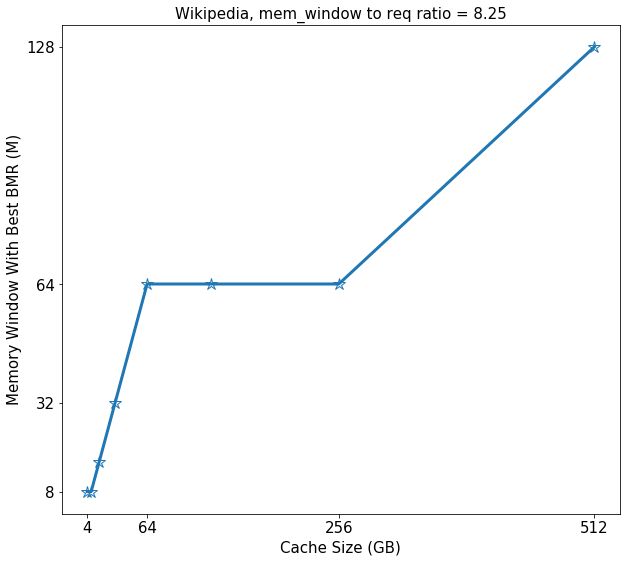

In [379]:
fig, ax = plt.subplots(figsize=(10, 9))

ax.plot(
    df2['cache_size'], 
    df2['forget_window'], 
    marker='*',
    markersize=12,
    markerfacecolor="None",
)

ax.set_xticks((4, 64, 256, 512))
ax.set_xticklabels(('4', '64', '256', '512')) 
ax.set_yticks((8, 32, 64, 128))
ax.set_yticklabels(('8', '32', '64', '128')) 
# plt.ylim([0, 0.84])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.xlabel(f'Cache Size (GB)')
plt.ylabel('Memory Window With Best BMR (M)')
plt.title(f'{trace_map[trace]}, mem_window to req ratio = 8.25')
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
# plt.savefig(f"{fig_dir}/evaluation_wiki.pdf",
#         bbox_inches = 'tight', 
#         pad_inches = 0)
plt.show()

In [380]:
(128*2**20)*(33*1024)/(512*2**30)

8.25

In [293]:
512*1024/128

4096.0

In [294]:
1024

1024

In [295]:
(512-4)*1024/120

4334.933333333333

In [381]:
trace = 'msr_rehash_200m.tr'
scale = 2**30
scale_label = 'GB'

# df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.sample_rate == '64')
    & (df.batch_size == '100000')
    & (df.objective == 'byte_hit_rate')
    & (df.uni_size == 0)
    & (df.cache_size.isin(trace_cache_sizes[trace]))
    & (df.n_warmup == 100000000)
    & (df.learning_rate == '0.1')
    & (df.num_iterations == '32')
    & (df.cache_size.isin(trace_cache_sizes[trace]))
#     & (df.cache_size == 34359738368)
#     & (df.cache_size == 17179869184)
#     & (df.cache_size == 8589934592)
#     & (df.cache_size == 4294967296)
    & (df.version == 'forward_window')
)

df1 = df[filter_idx].copy()


In [382]:
df1.groupby('cache_size').count()

,batch_size,byte_hit_rate,cache_type,cutoff,feature_overhead,forget_window,k,label,learning_rate,max_n_past_timestamps,...,sample_size,sample_type,segment_byte_hit_rate,segment_object_hit_rate,simulation_time,trace_file,training_sample_interval,uni_size,version,window
cache_size,,,,,,,,,,,,,,,,,,,,,
4.294967e+09,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
8.589935e+09,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
1.717987e+10,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
3.435974e+10,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
6.871948e+10,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
1.374390e+11,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
2.748779e+11,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
5.497558e+11,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0


In [383]:
df2 = df1[df1['byte_hit_rate'] == df1.groupby('cache_size')['byte_hit_rate'].transform(max)].drop_duplicates('cache_size').sort_values('byte_hit_rate')

In [384]:
df2['cache_size']/=1024*1024*1024
df2['forget_window']=df2['forget_window'].astype(float)
df2['forget_window']/=1024*1024

In [385]:
df2['forget_window'].astype(float)

5489      4.0
5484      8.0
5468      8.0
5463    256.0
5472    128.0
5467     64.0
5454    128.0
5443    128.0
Name: forget_window, dtype: float64

In [386]:
df2[['cache_size', 'forget_window']]

,cache_size,forget_window
5489,4.0,4.0
5484,8.0,8.0
5468,16.0,8.0
5463,32.0,256.0
5472,64.0,128.0
5467,128.0,64.0
5454,256.0,128.0
5443,512.0,128.0


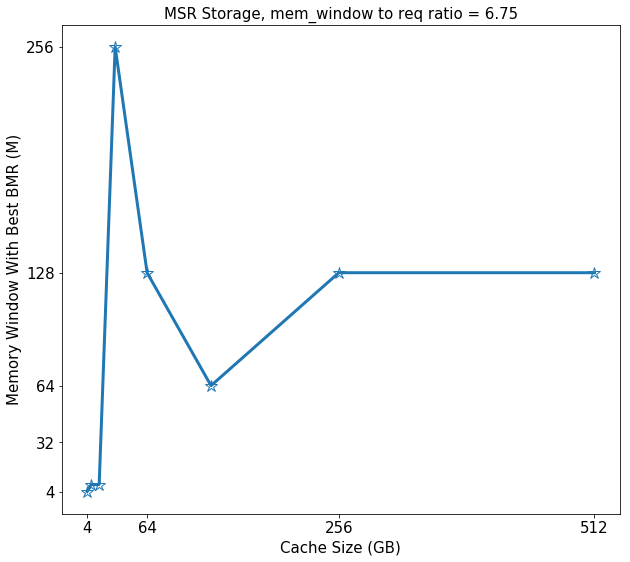

In [388]:
fig, ax = plt.subplots(figsize=(10, 9))

ax.plot(
    df2['cache_size'], 
    df2['forget_window'], 
    marker='*',
    markersize=12,
    markerfacecolor="None",
)

ax.set_xticks((4, 64, 256, 512))
ax.set_xticklabels(('4', '64', '256', '512')) 
ax.set_yticks((4, 32, 64, 128, 256))
ax.set_yticklabels(('4', '32', '64', '128', '256')) 
# plt.ylim([0, 0.84])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.xlabel(f'Cache Size (GB)')
plt.ylabel('Memory Window With Best BMR (M)')
plt.title(f'{trace_map[trace]}, mem_window to req ratio = 6.75')
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
# plt.savefig(f"{fig_dir}/evaluation_wiki.pdf",
#         bbox_inches = 'tight', 
#         pad_inches = 0)
plt.show()

In [317]:
(128*2**20)*(27*1024)/(512*2**30)

6.75

In [303]:
512*1024/128

4096.0

In [304]:
1024

1024

In [305]:
(512-4)*1024/120

4334.933333333333

In [389]:
trace = 'anonymous_200m.tr'
scale = 2**30
scale_label = 'GB'

# df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.sample_rate == '64')
    & (df.batch_size == '100000')
    & (df.objective == 'byte_hit_rate')
    & (df.uni_size == 0)
    & (df.cache_size.isin(trace_cache_sizes[trace]))
    & (df.n_warmup == warmup_map[trace])
    & (df.learning_rate == '0.1')
    & (df.num_iterations == '32')
    & (df.cache_size.isin(trace_cache_sizes[trace]))
#     & (df.cache_size == 34359738368)
#     & (df.cache_size == 17179869184)
#     & (df.cache_size == 8589934592)
#     & (df.cache_size == 4294967296)
    & (df.version == 'forward_window')
)

df1 = df[filter_idx].copy()


In [390]:
df1.groupby('cache_size').count()

,batch_size,byte_hit_rate,cache_type,cutoff,feature_overhead,forget_window,k,label,learning_rate,max_n_past_timestamps,...,sample_size,sample_type,segment_byte_hit_rate,segment_object_hit_rate,simulation_time,trace_file,training_sample_interval,uni_size,version,window
cache_size,,,,,,,,,,,,,,,,,,,,,
2.684355e+08,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
5.368709e+08,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
1.073742e+09,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
2.147484e+09,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
4.294967e+09,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
8.589935e+09,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
1.717987e+10,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0
3.435974e+10,10,10,10,0,10,10,0,10,10,10,...,0,0,10,10,10,10,10,10,10,0


In [391]:
df2 = df1[df1['byte_hit_rate'] == df1.groupby('cache_size')['byte_hit_rate'].transform(max)].drop_duplicates('cache_size').sort_values('byte_hit_rate')

In [392]:
df2['cache_size']/=1024*1024*1024
df2['forget_window']=df2['forget_window'].astype(float)
df2['forget_window']/=1024*1024

In [393]:
df2['forget_window'].astype(float)

5560     1.0
5575     1.0
5573     1.0
5615     1.0
5631     1.0
5648    16.0
5650    32.0
5651    32.0
Name: forget_window, dtype: float64

In [394]:
df2[['cache_size', 'forget_window']]

,cache_size,forget_window
5560,0.25,1.0
5575,0.50,1.0
5573,1.00,1.0
5615,2.00,1.0
5631,4.00,1.0
5648,8.00,16.0
5650,16.00,32.0
5651,32.00,32.0


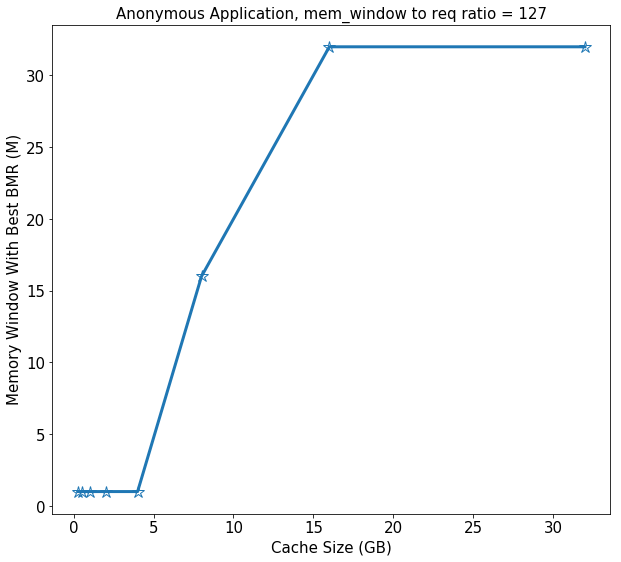

In [397]:
fig, ax = plt.subplots(figsize=(10, 9))

ax.plot(
    df2['cache_size'], 
    df2['forget_window'], 
    marker='*',
    markersize=12,
    markerfacecolor="None",
)

# ax.set_xticks((0.25, 1, 256, 512))
# ax.set_xticklabels(('4', '64', '256', '512')) 
# ax.set_yticks((4, 32, 64, 128, 256))
# ax.set_yticklabels(('4', '32', '64', '128', '256')) 
# plt.ylim([0, 0.84])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.xlabel(f'Cache Size (GB)')
plt.ylabel('Memory Window With Best BMR (M)')
plt.title(f'{trace_map[trace]}, mem_window to req ratio = 127')
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
# plt.savefig(f"{fig_dir}/evaluation_wiki.pdf",
#         bbox_inches = 'tight', 
#         pad_inches = 0)
plt.show()

In [396]:
(32*2**20)*(127*1024)/(32*2**30)

127.0

In [398]:
trace = 'memc_200m.tr'
scale = 2**30
scale_label = 'GB'

# df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.sample_rate == '64')
    & (df.batch_size == '100000')
    & (df.objective == 'byte_hit_rate')
    & (df.uni_size == 0)
    & (df.cache_size.isin(trace_cache_sizes[trace]))
    & (df.n_warmup == warmup_map[trace])
    & (df.learning_rate == '0.1')
    & (df.num_iterations == '32')
    & (df.cache_size.isin(trace_cache_sizes[trace]))
#     & (df.cache_size == 67108864)
#     & (df.cache_size == 17179869184)
#     & (df.cache_size == 8589934592)
#     & (df.cache_size == 4294967296)
#     & (df.version == 'forward_window')
)

df1 = df[filter_idx].copy()


In [399]:
df1[['forget_window', 'version', 'byte_hit_rate']]

,forget_window,version,byte_hit_rate
855,100000,revert_to_random,0.726594
926,200000,revert_to_random,0.798961
936,100000,revert_to_random,0.726631
993,500000,revert_to_random,0.856959
998,200000,revert_to_random,0.798993
1001,100000,revert_to_random,0.726631
1032,2000000,revert_to_random,0.910361
1036,1000000,revert_to_random,0.882202
1037,200000,revert_to_random,0.781359
1041,200000,revert_to_random,0.798993


In [400]:
df1.groupby('cache_size').count()

,batch_size,byte_hit_rate,cache_type,cutoff,feature_overhead,forget_window,k,label,learning_rate,max_n_past_timestamps,...,sample_size,sample_type,segment_byte_hit_rate,segment_object_hit_rate,simulation_time,trace_file,training_sample_interval,uni_size,version,window
cache_size,,,,,,,,,,,,,,,,,,,,,
6.710886e+07,25,25,25,0,10,25,0,25,25,25,...,0,0,25,25,25,25,25,25,25,0
1.342177e+08,25,25,25,0,10,25,0,25,25,25,...,0,0,25,25,25,25,25,25,25,0
2.684355e+08,25,25,25,0,10,25,0,25,25,25,...,0,0,25,25,25,25,25,25,25,0
5.368709e+08,25,25,25,0,10,25,0,25,25,25,...,0,0,25,25,25,25,25,25,25,0
1.073742e+09,25,25,25,0,10,25,0,25,25,25,...,0,0,25,25,25,25,25,25,25,0
2.147484e+09,25,25,25,0,10,25,0,25,25,25,...,0,0,25,25,25,25,25,25,25,0
4.294967e+09,25,25,25,0,10,25,0,25,25,25,...,0,0,25,25,25,25,25,25,25,0
8.589935e+09,25,25,25,0,10,25,0,25,25,25,...,0,0,25,25,25,25,25,25,25,0


In [401]:
df2 = df1[df1['byte_hit_rate'] == df1.groupby('cache_size')['byte_hit_rate'].transform(max)].drop_duplicates('cache_size').sort_values('byte_hit_rate')

In [402]:
df2['cache_size']/=1024*1024*1024
df2['forget_window']=df2['forget_window'].astype(float)
df2['forget_window']/=1024*1024

In [403]:
df2['forget_window'].astype(float)

1515     0.190735
1450     0.476837
5557     1.000000
5548     2.000000
5539     8.000000
5534    16.000000
1368    19.073486
5516    32.000000
Name: forget_window, dtype: float64

In [404]:
df2[['cache_size', 'forget_window']]

,cache_size,forget_window
1515,0.0625,0.190735
1450,0.1250,0.476837
5557,0.2500,1.000000
5548,0.5000,2.000000
5539,1.0000,8.000000
5534,2.0000,16.000000
1368,4.0000,19.073486
5516,8.0000,32.000000


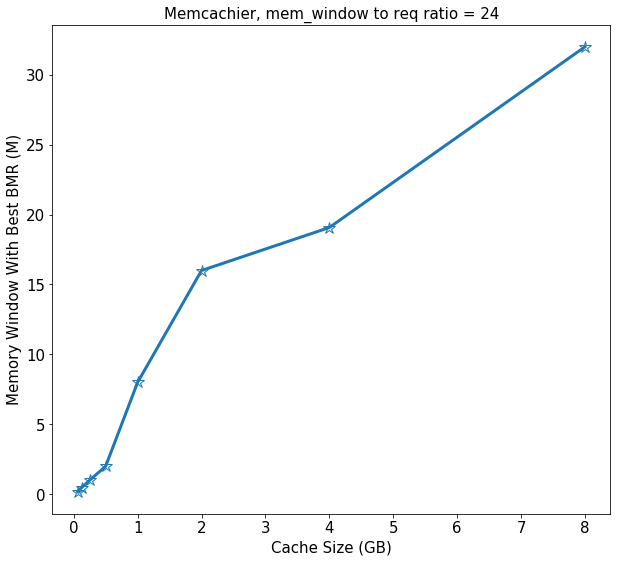

In [406]:
fig, ax = plt.subplots(figsize=(10, 9))

ax.plot(
    df2['cache_size'], 
    df2['forget_window'], 
    marker='*',
    markersize=12,
    markerfacecolor="None",
)

# ax.set_xticks((4, 64, 256, 512))
# ax.set_xticklabels(('4', '64', '256', '512')) 
# ax.set_yticks((4, 32, 64, 128, 256))
# ax.set_yticklabels(('4', '32', '64', '128', '256')) 
# plt.ylim([0, 0.84])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.xlabel(f'Cache Size (GB)')
plt.ylabel('Memory Window With Best BMR (M)')
plt.title(f'{trace_map[trace]}, mem_window to req ratio = 24')
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
# plt.savefig(f"{fig_dir}/evaluation_wiki.pdf",
#         bbox_inches = 'tight', 
#         pad_inches = 0)
plt.show()

In [329]:
(32*2**20)*(6*1024)/(8*2**30)

24.0